In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, layers, optimizers, metrics, models
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 5

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True, # 랜덤하게 50%를 생성
                                   width_shift_range = 0.1, # 좌/우 10% 범위 내에서 이동
                                   height_shift_range = 0.1, # 상/하 10% 범위 내에서 이동
                                   fill_mode = 'nearest')

train_generator = train_datagen.flow_from_directory('train',
                                                    target_size = (150, 150),
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'binary')

test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory('test',
                                                    target_size = (150, 150),
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'binary')

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [3]:
transfer_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (150, 150, 3))
transfer_model.trainable = False

In [4]:
finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(Flatten())
finetune_model.add(Dense(64))
finetune_model.add(Activation('relu'))
finetune_model.add(Dropout(0.5))
finetune_model.add(Dense(1))
finetune_model.add(Activation('sigmoid'))
finetune_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                524352    
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0

In [5]:
finetune_model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(learning_rate = 0.0002),
              metrics= ['accuracy'])

In [6]:
steps_train = len(train_generator)
steps_test = len(test_generator)

In [7]:
history = finetune_model.fit(train_generator,
                   steps_per_epoch=steps_train,
                   epochs=20,
                   validation_data=test_generator,
                   validation_steps=steps_test)

Epoch 1/20
32/32 [==============================] - 14s 453ms/step - loss: 0.6918 - accuracy: 0.6000 - val_loss: 0.5644 - val_accuracy: 0.7333
Epoch 2/20
32/32 [==============================] - 14s 449ms/step - loss: 0.5741 - accuracy: 0.7188 - val_loss: 0.5050 - val_accuracy: 0.7917
Epoch 3/20
32/32 [==============================] - 15s 453ms/step - loss: 0.4730 - accuracy: 0.7688 - val_loss: 0.4214 - val_accuracy: 0.8417
Epoch 4/20
32/32 [==============================] - 15s 456ms/step - loss: 0.3968 - accuracy: 0.8875 - val_loss: 0.3703 - val_accuracy: 0.8917
Epoch 5/20
32/32 [==============================] - 15s 456ms/step - loss: 0.3907 - accuracy: 0.8375 - val_loss: 0.3416 - val_accuracy: 0.9083
Epoch 6/20
32/32 [==============================] - 15s 458ms/step - loss: 0.3344 - accuracy: 0.9000 - val_loss: 0.3089 - val_accuracy: 0.9167
Epoch 7/20
32/32 [==============================] - 15s 461ms/step - loss: 0.2930 - accuracy: 0.9125 - val_loss: 0.3064 - val_accuracy: 0.8833

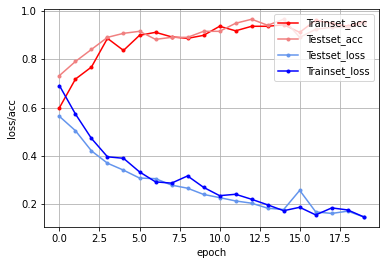

In [11]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, acc, marker='.', c="red", label='Trainset_acc')
plt.plot(x_len, val_acc, marker='.', c="lightcoral", label='Testset_acc')
plt.plot(x_len, y_vloss, marker='.', c="cornflowerblue", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

plt.legend(loc='upper right') 
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()